In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [4]:
from rate_training import *

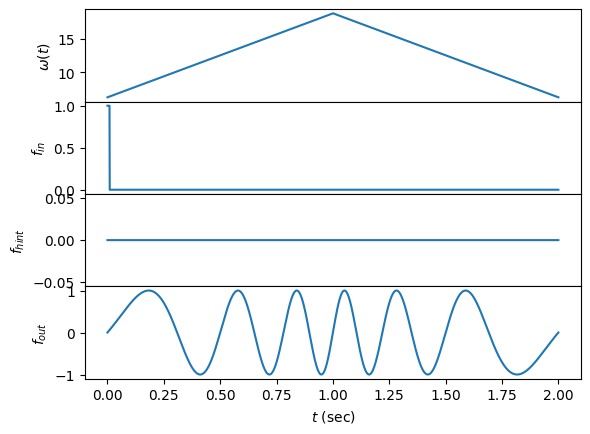

In [5]:
def inps_and_targs(dt, plot=False):
    t = np.linspace(0, 2, int(1./dt))
    
    omega = np.zeros(t.shape)
    omega[:int(t.shape[0]/2)] = np.linspace(2*np.pi, 6*np.pi, int(t.shape[0]/2))
    omega[int(t.shape[0]/2):] = np.flipud(omega[:int(t.shape[0]/2)]) # increasing decreasing (frequency of sin in fout)
    
    fout = np.zeros(t.shape)
    fout[:int(t.shape[0]/2)] = np.sin(omega[:int(t.shape[0]/2)] * t[:int(t.shape[0]/2)])
    fout[int(t.shape[0]/2):] = -np.flipud(fout[:int(t.shape[0]/2)])

    fhint = np.zeros(t.shape)

    fin = np.zeros(t.shape)
    fin[:10] = np.ones(10)

    fin = np.reshape(fin, (1, fin.size)).T
    fout = np.reshape(fout, (1, fout.size)).T
    fhint = np.reshape(fhint, (1, fhint.size)).T

    if plot:
        fig, axs = plt.subplots(4, 1, sharex=True)
        plt.subplots_adjust(hspace=0)
        labels = ['$\omega (t)$', '$f_{in}$', '$f_{hint}$', '$f_{out}$']
        for ax, y, label in zip(axs, [omega, fin, fhint, fout], labels):
            ax.plot(t, y)
            ax.set_ylabel(label)
        axs[-1].set_xlabel('$t$ (sec)')

    return (fin, fout, fhint)

dt = 0.0005 # 1/dt total timesteps
fin, fout, _ = inps_and_targs(dt, plot=True)

In [6]:
np.shape(fout)

(2000, 1)

In [7]:
npar, tpar, trpar, cpar, rpar = create_default_params()
tpar['dt'] = 1
tpar['total_time'] = 2000
rpar['run_time'] = 2000

In [8]:
dnet = rate_training(npar, tpar, trpar, cpar, rpar)

In [9]:
npar

{'net_size': 200, 'tau_x': 10, 'gain': 1.2}

In [22]:
uin = sp.stats.uniform.rvs(size = npar['net_size']) * 2 - 1
uout = sp.stats.uniform.rvs(size = npar['net_size']) * 2 - 1

In [23]:
ufin = np.transpose(np.multiply(fin, uin))
ufout = np.transpose(np.multiply(fout, uout))

In [24]:
x, Hx = dnet.run_rate(ufin + ufout)

Text(0.5, 1.0, 'Sample driven neuronal behavior')

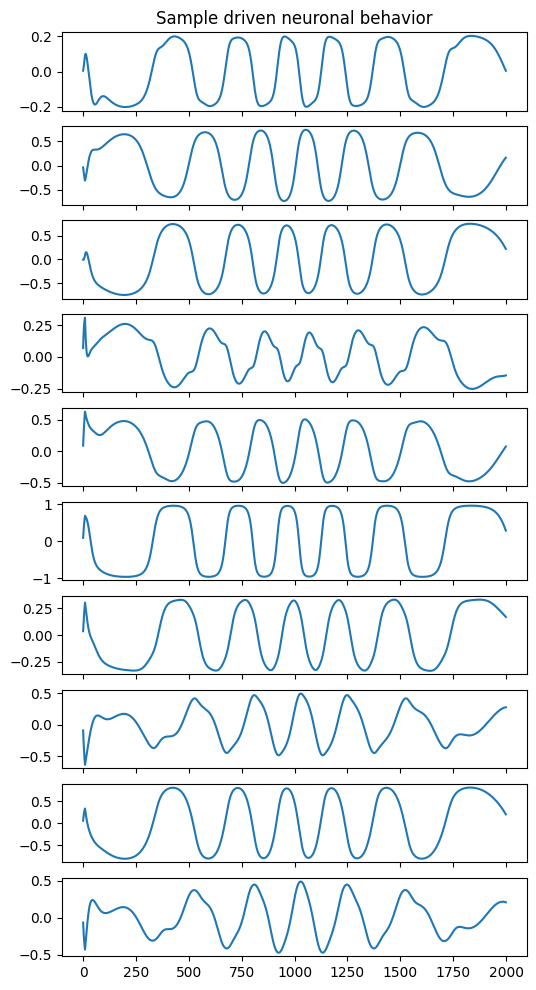

In [25]:
n_plot = 10

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Hx[i])
    #axs[i].plot(x[i])
    #axs[i].plot(ufin[i] + ufout[i])

axs[0].set_title("Sample driven neuronal behavior")

In [26]:
tnet = rate_training(npar, tpar, trpar, cpar, rpar)

In [30]:
tnet.stim_off = 10
tnet.nloop = 20

In [31]:
aux_targs = Hx + ufout
np.shape(aux_targs)

(200, 2000)

In [32]:
xt, Hxt, errs = tnet.train_rate(ufin, aux_targs)

training trial 0
training trial 1
training trial 2
training trial 3
training trial 4
training trial 5
training trial 6
training trial 7
training trial 8
training trial 9
training trial 10
training trial 11
training trial 12
training trial 13
training trial 14
training trial 15
training trial 16
training trial 17
training trial 18
training trial 19


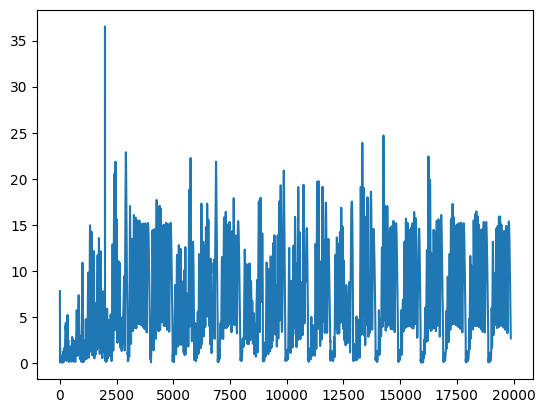

In [33]:
plt.plot(errs)

Text(0.5, 1.0, 'Sample driven neuronal behavior')

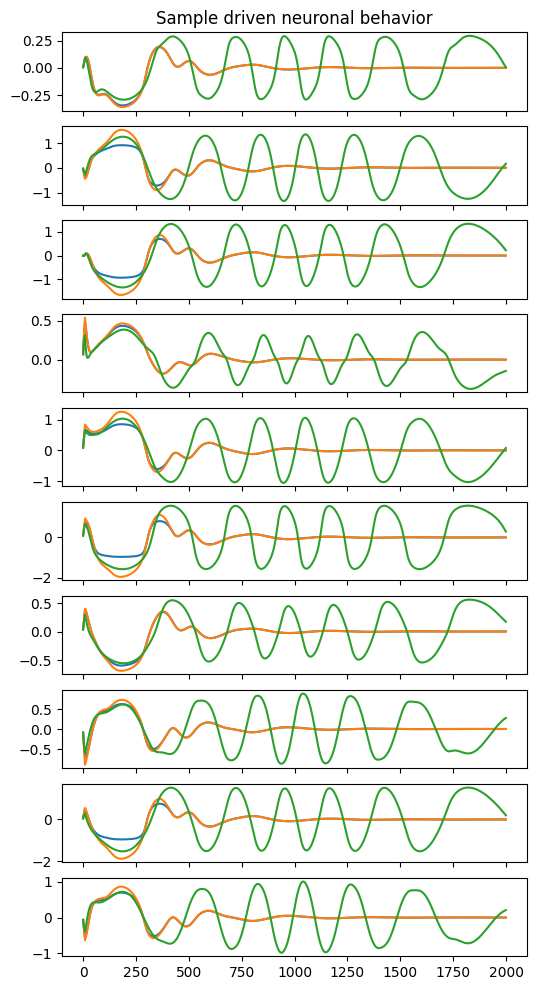

In [34]:
xr, Hxr = tnet.run_rate(ufin)

n_plot = 10

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Hxr[i])
    axs[i].plot(xr[i])
    axs[i].plot(aux_targs[i])

axs[0].set_title("Sample driven neuronal behavior")

Text(0.5, 1.0, 'Sample task-generating internal behavior')

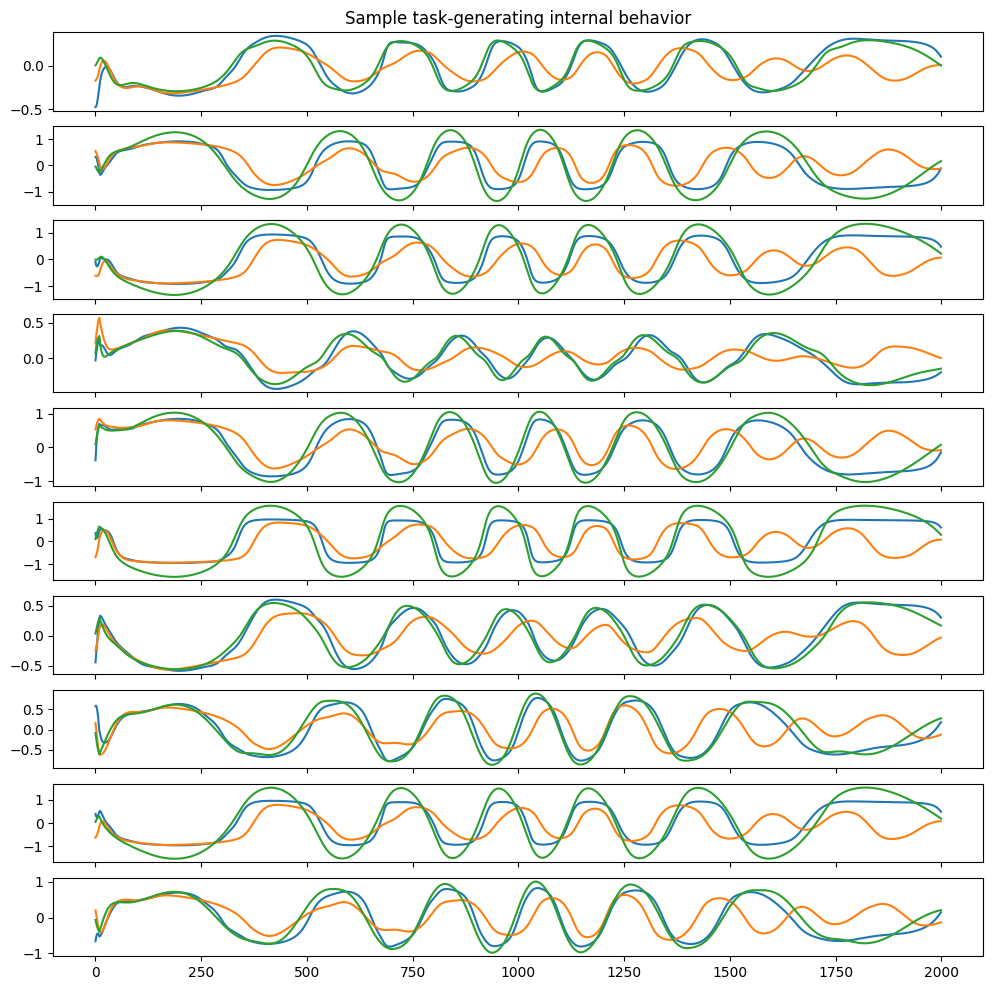

In [37]:
n_plot = 10
nloop = trpar['training_loops']
timesteps = int(tpar['total_time']/tpar['dt'])

fig, axs = plt.subplots(n_plot, 1, figsize = (12, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Hxt[i, 0:timesteps])
    #axs[i].plot(Hxt[i])
    axs[i].plot(Hxt[i, (nloop - 1)*timesteps:nloop*timesteps])
#     axs[i].plot(x[i])
    axs[i].plot(aux_targs[i])
    #axs[i].plot(ufin[i])

axs[0].set_title("Sample task-generating internal behavior")

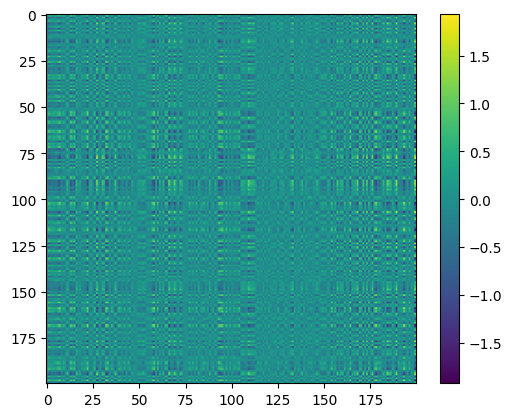

In [36]:
plt.imshow(tnet.W_trained)
plt.colorbar()

In [63]:
r = np.array([[1], [2], [3]])
P = np.array([[1, 2, 3], [3, 4, 2], [1, 1, 2]])

In [72]:
Pr = np.dot(P, r)
Pr

array([[14],
       [17],
       [ 9]])

In [73]:
rc = np.array([1, 2, 3])
np.dot(P, rc)

array([14, 17,  9])

In [67]:
1 + np.dot(rc, np.dot(P, rc))

76

In [80]:
k = np.transpose(Pr)/(1 + np.dot(np.transpose(r), Pr))
k

array([[0.18421053, 0.22368421, 0.11842105]])

In [81]:
np.dot(Pr, k)

array([[2.57894737, 3.13157895, 1.65789474],
       [3.13157895, 3.80263158, 2.01315789],
       [1.65789474, 2.01315789, 1.06578947]])

In [82]:
np.outer(np.dot(P, rc), np.dot(P, rc)) / (1 + np.dot(rc, np.dot(P, rc)))

array([[2.57894737, 3.13157895, 1.65789474],
       [3.13157895, 3.80263158, 2.01315789],
       [1.65789474, 2.01315789, 1.06578947]])